# Parametrization of axis-symmetric steady bubble shapes

Three bubbles are investigated:
- dimpled ellipsoidal $Eo=243$, $Mo=266$, $Ga^\prime=15.24$
- spherical cap (closed wake) $Eo=115$, $Mo=4.63\times 10^{-3}$, $Ga^\prime = 135$
- $d_{eq}=1.8~mm$ bubble in water at 20°C corresponding to $Eo=0.4361$, $Mo=2.5728\times 10^{-11}$, $Ga^\prime = 238.29$
    
Itersections of the piecewise linear interface reconstruction with the underlying background mesh are called *PLIC points* hereafter.

The main steps are:
1. select time instances and select corresponding iteration/bubble center/PLIC points
2. read PLIC points from disk and convert them to a polar coordinate system with the orgin being the (geometrical) bubble center
3. compare several approaches to approximate the shape
4. create a 2D STL file based on the shape approximation

## Load facets for given time instances

In [14]:
import helper_module as hm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, InsetPosition, mark_inset
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.filters import gaussian_filter1d
from scipy import interpolate
from sklearn.neighbors import KernelDensity
import itertools
import torch

%matplotlib inline

# make torch results reproducible and use double precision
torch.set_default_tensor_type(torch.DoubleTensor)
torch.manual_seed(42)
np.random.seed(42)

data_path = "../data/"
names = ["dell_l17", "scap_l16", "wa18_l16"]
times = [50, 50, 20]
output_path = "../output/models"
!mkdir -p ../output/models
!mkdir -p ../output/STL

cases = [data_path + name for name in names]

for i, case in enumerate(cases):
    print(i, case, times[i])
    
# convinience function for saving plots as png and pdf
def savefig(name):
    output_path = "../output/"
    plt.savefig(output_path + name + ".png", bbox_inches="tight", dpi=300)
    plt.savefig(output_path + name + ".pdf", bbox_inches="tight")

0 ../data/dell_l17 50
1 ../data/scap_l16 50
2 ../data/wa18_l16 20


In [2]:
all_facets = {}
for i, case in enumerate(cases):
    log_path = case + "/log." + names[i] + ".csv"
    log = hm.Logfile(log_path)
    log.read_logfile(usecols=['time', 'x'])
    row = log.find_closest("time", times[i])
    plic_path = case + "/plic_clean/plic_{:06d}.pkl".format(row.index.values[0]*10)
    all_facets[names[i]] = hm.FacetCollection2D(plic_path, [0, row.x.values[0]], True)

Successfully read file ../data/dell_l17/log.dell_l17.csv
Successfully read file ../data/dell_l17/plic_clean/plic_290030.pkl
Successfully read file ../data/scap_l16/log.scap_l16.csv
Successfully read file ../data/scap_l16/plic_clean/plic_149210.pkl
Successfully read file ../data/wa18_l16/log.wa18_l16.csv
Successfully read file ../data/wa18_l16/plic_clean/plic_968510.pkl


## Plot facets in polar coordinates

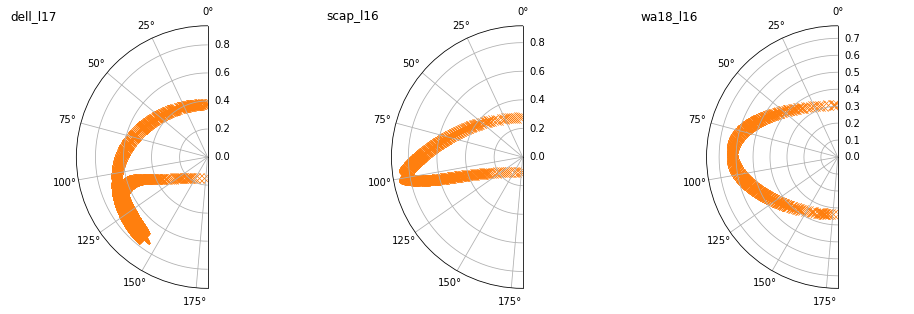

In [3]:
rc('text', usetex=False)
fig, axarr = plt.subplots(1, 3, figsize=(hm.figure_width, 6), subplot_kw=dict(projection='polar'))

for i, name in enumerate(names):
    rad, phi = all_facets[name].get_facets(polar=True)
    axarr[i].scatter(phi, rad, marker="x", color="C1", s=100, lw=0.5)
    axarr[i].set_theta_zero_location("N")
    axarr[i].set_xlim(0.0, np.pi)
    axarr[i].set_title(name, loc='left')

## Approximate simple shapes (star-shaped sets)
### Add points to improve symmetry, rescale with aspect ratio

In [4]:
def compute_aspect_ratio(facets):
    """Compute the aspect ratio of a point cloud (x_i, y_i).
       The function assumes axial symmetry with respect to they axis.
       
    Parameters
    ----------
    facets - instance of FacetCollection2D
    
    Returns
    -------
    aspect ratio of the full contour
    
    """
    x, y = facets.get_facets(polar=False)
    dx = np.max(x) - np.min(x)
    dy = np.max(y) - np.min(y)
    return 2 * dx / dy

In [5]:
phi_ext = {}
rad_ext = {}

# number of points to add at phi=0 and phi=pi
Np = 10
for i, name in enumerate(["scap_l16", "wa18_l16"]):
    x, y = np.array(all_facets[name].get_facets(polar=False))
    ys = y * compute_aspect_ratio(all_facets[name])
    rads, phis = hm.transform_polar_2D(x, ys)
    phi_order = np.argsort(phis)
    phi_sorted = phis[phi_order]
    rad_sorted = rads[phi_order]
    phi_ext[name] = np.concatenate((-phi_sorted[:Np+1], phi_sorted, 2*np.pi - phi_sorted[-Np:]), axis=0)
    rad_ext[name] = np.concatenate((rad_sorted[:Np+1], rad_sorted, rad_sorted[-Np:]), axis=0)

### Parameterization - simple shapes

min/max/diff of radius for case scap_l16 before scaling
0.1024/0.8400/0.7376
min/max/diff of radius for case scap_l16 after scaling
0.3848/1.0407/0.6559
min/max/diff of radius for case wa18_l16 before scaling
0.3058/0.6250/0.3192
min/max/diff of radius for case wa18_l16 after scaling
0.5944/0.6549/0.0605


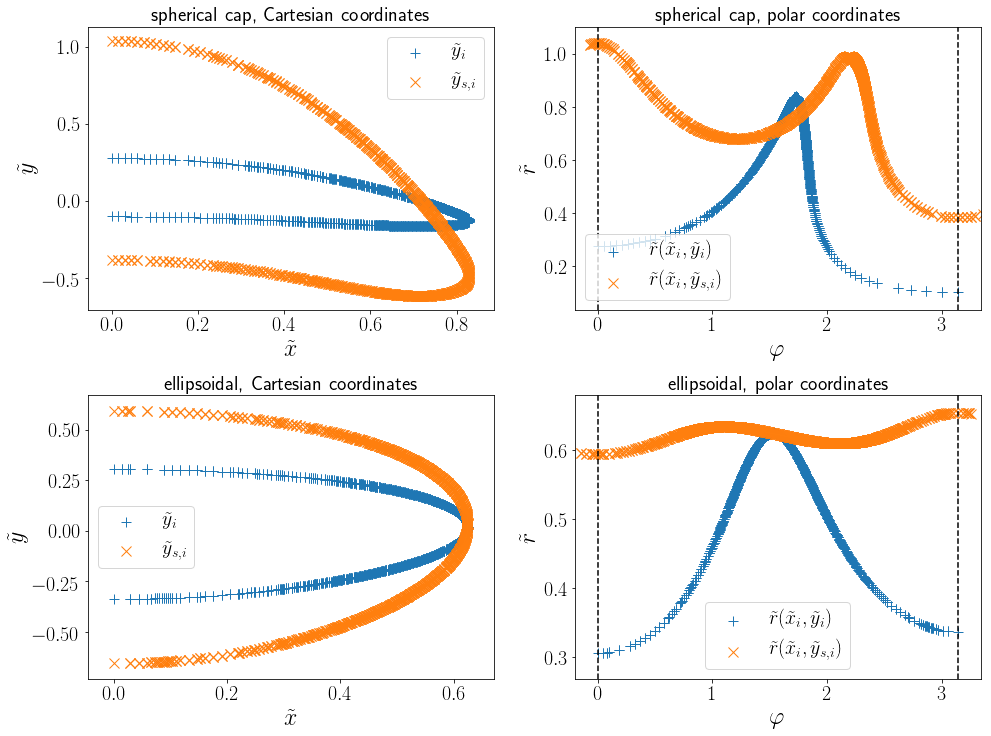

In [6]:
rc('text', usetex=True)
fig, axarr = plt.subplots(2, 2, figsize=(hm.figure_width, 12))

for i, case in enumerate(["scap_l16", "wa18_l16"]):
    
    # original data
    rad, phi = all_facets[case].get_facets(polar=True)
    x, y = all_facets[case].get_facets(polar=False)
    # scaled data
    ys = y * compute_aspect_ratio(all_facets[case])
    
    # plot as Cartesian coordinates
    axarr[i, 0].scatter(x, y, color="C0", lw=1, s=120, marker="+", label=r"$\tilde{y}_i$")
    axarr[i, 0].scatter(x, ys, color="C1", lw=1, s=100, marker="x", label=r"$\tilde{y}_{s,i}$")
    axarr[i, 0].set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)
    axarr[i, 0].set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)
    
    # plot as polar coordinates
    axarr[i, 1].scatter(phi, rad, color="C0", lw=1, s=120, marker="+", label=r"$\tilde{r}(\tilde{x}_i,\tilde{y}_i)$")
    axarr[i, 1].scatter(phi_ext[case], rad_ext[case], color="C1", lw=1, s=100, marker="x", label=r"$\tilde{r}(\tilde{x}_i,\tilde{y}_{s,i})$")
    axarr[i, 1].axvline(0.0, ls="--", color="k")
    axarr[i, 1].axvline(np.pi, ls="--", color="k")
    axarr[i, 1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
    axarr[i, 1].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)
    axarr[i, 1].set_xlim(-0.2, 3.34)
    
    print("min/max/diff of radius for case {} before scaling".format(case))
    print("{:1.4f}/{:1.4f}/{:1.4f}".format(np.min(rad), np.max(rad), np.max(rad) - np.min(rad)))
    print("min/max/diff of radius for case {} after scaling".format(case))
    print("{:1.4f}/{:1.4f}/{:1.4f}".format(np.min(rad_ext[case]), np.max(rad_ext[case]), np.max(rad_ext[case]) - np.min(rad_ext[case])))

titles = [
    "spherical cap, Cartesian coordinates",
    "spherical cap, polar coordinates",
    "ellipsoidal, Cartesian coordinates",
    "ellipsoidal, polar coordinates",
]
for i, ax in enumerate(itertools.chain(*axarr)):
    ax.tick_params(labelsize=hm.fontsize_tick)
    ax.legend(fontsize=hm.fontsize_legend)
    ax.set_title(titles[i], fontsize=hm.fontsize_legend)
    
plt.subplots_adjust(hspace=0.3)
savefig("polar_parameterization")

### MLP approximation - simple shapes

In [7]:
model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

In [8]:
all_losses = {}
all_models = {}

epochs = 5000
for case in ["scap_l16", "wa18_l16"]:
    rad = rad_ext[case]
    phi = phi_ext[case]
    rad_norm = (rad - np.min(rad)) / (np.max(rad) - np.min(rad))
    phi_norm = phi / np.pi
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path + "/{}_4layers_40nodes.pt".format(case)
    model, losses = hm.training_loop(model, model_path, phi_norm, rad_norm, None, epochs, 0.01)
    all_losses[case] = losses

100%|██████████| 5000/5000 [00:32<00:00, 152.28it/s]


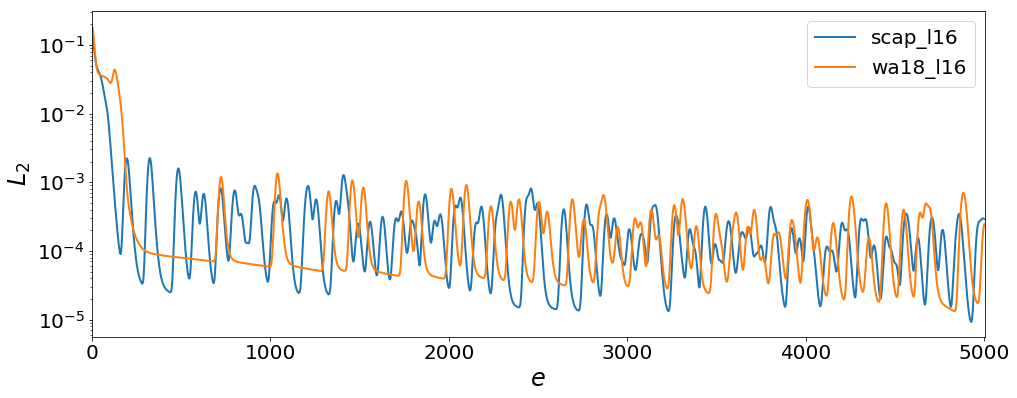

In [9]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

colors = ["C{:1d}".format(i) for i in range(2)]

for i, key in enumerate(all_losses.keys()):
    smoothed = gaussian_filter1d(all_losses[key], sigma=10)
    ax.plot(range(1, epochs+1), smoothed, ls="-", lw=2, color=colors[i], label=key)
    
ax.set_xlabel("$e$", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)
savefig("loss_over_epochs_simple_shapes")

In [10]:
def denormalize(rads, phis, facets):
    x, y = facets.get_facets(polar=False)
    aspect_ratio = compute_aspect_ratio(facets)
    ys = y * aspect_ratio
    rad_ref, phi_ref = hm.transform_polar_2D(x, ys)
    phi_org = phis * np.pi
    rad_org = rads * (np.max(rad_ref) - np.min(rad_ref)) + np.min(rad_ref)
    px, py = hm.transform_cartesian_2D(rad_org, phi_org)
    return hm.transform_polar_2D(px, py/aspect_ratio)


def evaluate_shape_model(model_path, facets, points=False, n_points=200):
    if points:
        x, y = facets.get_facets(polar=False)
        aspect_ratio = compute_aspect_ratio(facets)
        ys = y * aspect_ratio
        rad_ref, phi_ref = hm.transform_polar_2D(x, ys)
        phi_norm = phi_ref / np.pi
    else:
        phi_norm = np.linspace(0, 1, n_points)
    model = hm.SimpleMLP(**model_dict)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    phi_eval = torch.from_numpy(phi_norm.astype(np.float64)).unsqueeze_(-1)
    rad_norm = model.forward(phi_eval).detach().squeeze().numpy()
    return denormalize(rad_norm, phi_norm, facets)


def compute_error_norms(model_path, facets):
    radm, phim = evaluate_shape_model(model_path, facets, True)
    rad, phi = facets.get_facets(polar=True)
    diff = np.absolute(radm - rad)
    L2 = np.mean(np.square(diff))
    L1 = np.mean(diff)
    Linf = np.max(diff)
    Linf_rel = np.max(diff / rad)
    return [L2, L1, Linf, Linf_rel]


def format_exp_latex(number):
    expo = int(np.floor(np.log10(abs(number))))
    latex = "{:2.4f}".format(number/10**expo) + "e^{" + "{:02d}".format(expo) + "}"
    return latex

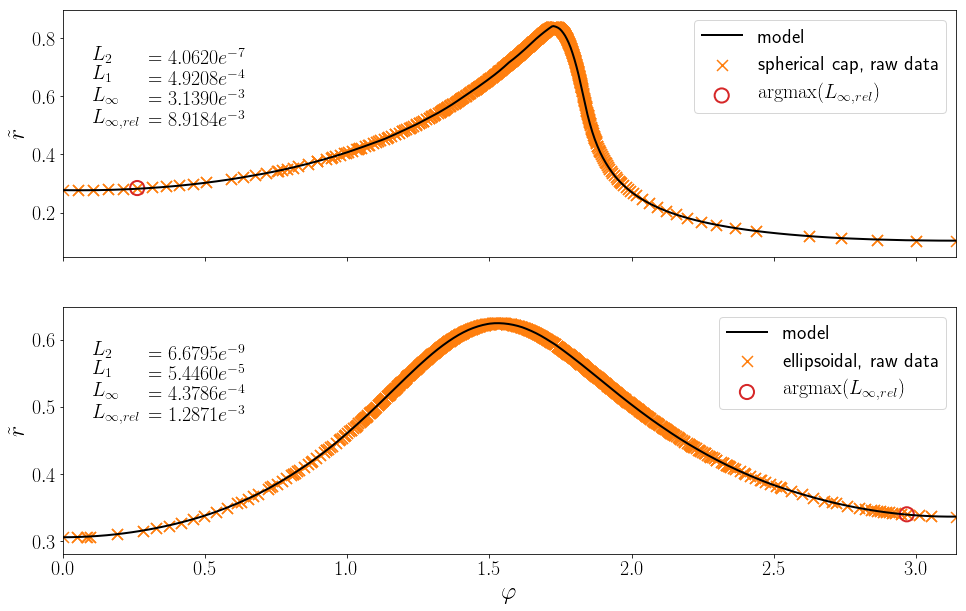

In [11]:
rc('text', usetex=True)
fig, axarr = plt.subplots(2, 1, figsize=(hm.figure_width, 10), sharex=True)

labels = ["spherical cap, raw data", "ellipsoidal, raw data"]
y_pos = [0.5, 0.48]

for i, case in enumerate(["scap_l16", "wa18_l16"]):
    
    # plot model output and raw data
    model_path = output_path + "/{}_4layers_40nodes.pt".format(case)
    rad_model, phi_model = evaluate_shape_model(model_path, all_facets[case], False)
    rad_data, phi_data = all_facets[case].get_facets(polar=True)
    axarr[i].plot(phi_model, rad_model, color="k", lw=2, label="model")
    axarr[i].scatter(phi_data, rad_data, color="C1", marker="x", s=120, label=labels[i])
    
    # print error norms
    L2, L1, Linf, Linf_rel = compute_error_norms(model_path, all_facets[case])
    axarr[i].text(0.1, y_pos[i], "$L_2$\n$L_1$\n$L_\infty$\n$L_{\infty,rel}$", fontsize=hm.fontsize_tick)
    axarr[i].text(0.3, y_pos[i], "$=" + format_exp_latex(L2) + "$\n"
                  + "$=" + format_exp_latex(L1) + "$\n"
                  + "$=" + format_exp_latex(Linf) + "$\n"
                  + "$=" + format_exp_latex(Linf_rel) + "$", fontsize=hm.fontsize_tick)
    
    # max location of maximum relative error
    rad_model, phi_model = evaluate_shape_model(model_path, all_facets[case], True)
    diff = np.absolute((rad_model - rad_data) / rad_data)
    axarr[i].scatter([phi_data[np.argmax(diff)]],[rad_data[np.argmax(diff)]],
                     marker="o", facecolors='none', edgecolors='C3', s=200, lw=2,
                     label="$\mathrm{argmax}(L_{\infty ,rel})$")
    
    # formatting
    axarr[i].set_xlim(0, np.pi)
    axarr[i].tick_params(labelsize=hm.fontsize_tick)
    axarr[i].legend(fontsize=hm.fontsize_legend)
    axarr[i].set_ylabel(r"$\tilde{r}$", fontsize=hm.fontsize_label)

    
axarr[-1].set_xlabel(r"$\varphi$", fontsize=hm.fontsize_label)
savefig("radius_simple_shapes")

## Approximate the shape of dimpled ellipsoidal bubble

In [12]:
def find_closest_point(point, point_list):
    diff = np.linalg.norm(point_list - point, axis=1)
    return np.argmin(diff)


def order_points(facets):
    rad, phi = facets.get_facets(polar=True)
    x, y = facets.get_facets(polar=False)
    order = np.ones(rad.shape[0], dtype=np.intp)
    order[0] = np.argmin(phi)
    current_point = np.asarray([x[order[0]], y[order[0]]])
    x[order[0]] = 10
    y[order[0]] = 10
    for i in range(1, order.shape[0]):
        order[i] = find_closest_point(current_point, np.asarray([x, y]).T)
        current_point = np.asarray([x[order[i]], y[order[i]]])
        x[order[i]] = 10
        y[order[i]] = 10
    x, y = facets.get_facets(polar=False)
    return x[order], y[order]

In [30]:
xs, ys = order_points(all_facets["dell_l17"])

length = np.zeros(xs.shape[0])
dist = np.zeros(xs.shape[0] - 1)

for i in range(1, xs.shape[0]):
    dist[i-1] = np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2)
    length[i] = length[i-1] + dist[i-1]

# add points to improve symmetry
Np = 10
length_ext = np.concatenate((-length[2*Np:0:-1], length, 2 * length[-1] - length[:-Np-1:-1]), axis=0)
xs_ext = np.concatenate((-xs[2*Np:0:-1], xs, 2 * xs[-1] - xs[:-Np-1:-1]), axis=0)
ys_ext = np.concatenate(( ys[2*Np:0:-1], ys, 2 * ys[-1] - ys[:-Np-1:-1]), axis=0)

for before, after in zip([length, xs, ys], [length_ext, xs_ext, ys_ext]):
    print("original length: {}, new length: {}, difference: {}".format(
        before.shape[0], after.shape[0], after.shape[0] - before.shape[0]))
    
# export data to csv for later use
df = pd.DataFrame(np.vstack((xs, ys, length)).T, columns=["xs", "ys", "length"])
df.to_csv(data_path + "dell_l17/arc_length.csv", index=False)

original length: 3714, new length: 3744, difference: 30
original length: 3714, new length: 3744, difference: 30
original length: 3714, new length: 3744, difference: 30


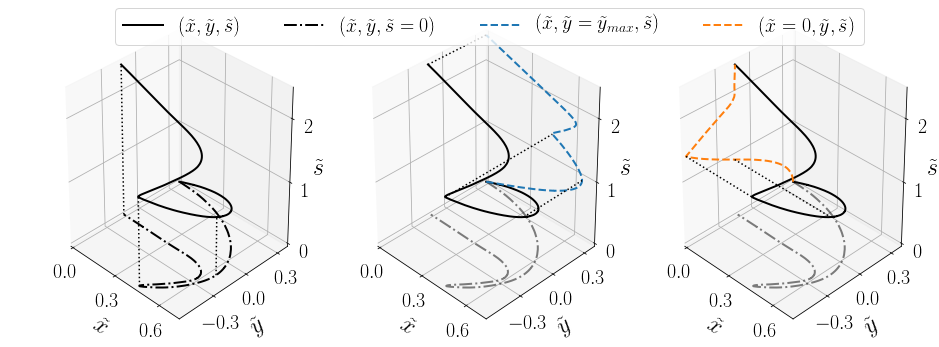

In [14]:
fig = plt.figure(figsize=(hm.figure_width, 6))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

x_max = np.max(xs) * 1.1
y_max = np.max(ys) * 1.0
y_min = np.min(ys) * 1.0

# commom features
for ax in [ax1, ax2, ax3]:
    line0 = ax.plot(xs, ys, length, lw=2, color="k", label=r"$(\tilde{x},\tilde{y},\tilde{s})$")
    ax.set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)
    ax.set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)
    ax.set_zlabel(r"$\tilde{s}$", fontsize=hm.fontsize_label)
    ax.zaxis.set_rotate_label(False) 
    ax.xaxis.labelpad=10
    ax.yaxis.labelpad=10
    ax.zaxis.labelpad=0
    ax.set_xlim(0, x_max)
    ax.set_ylim(y_min, y_max)
    ax.tick_params(labelsize=hm.fontsize_tick)
    ax.view_init(30, -45)
    ax.set_xticks(np.linspace(0.0, 0.6, 3))
    ax.set_yticks([-0.3, 0.0, 0.3])
    
# plot 1
line1 = ax1.plot(xs, ys, np.zeros(xs.shape[0]), ls="-.", color="k", lw=2, label=r"$(\tilde{x}, \tilde{y}, \tilde{s}=0)$")

mark_at = [np.argmax(xs), np.argmin(ys), xs.shape[0]-1]
for ind in mark_at:
    ax1.plot([xs[ind], xs[ind]], [ys[ind], ys[ind]], [0.0, length[ind]], ls=":", color="k", alpha=1.0)
    
# plot 2
ax2.plot(xs, ys, np.zeros(xs.shape[0]), ls="-.", color="k", lw=2, alpha=0.5)
line2 = ax2.plot(xs, np.ones(ys.shape[0]) * y_max, length, ls="--", lw=2, color="C0", alpha=1.0, label=r"$(\tilde{x}, \tilde{y}=\tilde{y}_{max}, \tilde{s})$")

mark_at = [np.argmax(xs), np.argmin(ys), xs.shape[0]-1]
for ind in mark_at:
    ax2.plot([xs[ind], xs[ind]], [ys[ind], y_max], [length[ind], length[ind]], ls=":", color="k", alpha=1.0)
    
# plot 3
ax3.plot(xs, ys, np.zeros(xs.shape[0]), ls="-.", color="k", lw=2, alpha=0.5)
line3 = ax3.plot(np.zeros(xs.shape[0]), ys, length, ls="--", lw=2, color="C1", alpha=1.0, label=r"$(\tilde{x}=0, \tilde{y}, \tilde{s})$")

mark_at = [np.argmax(xs), np.argmin(ys), xs.shape[0]-1]
for ind in mark_at:
    ax3.plot([0.0, xs[ind]], [ys[ind], ys[ind]], [length[ind], length[ind]], ls=":", color="k", alpha=1.0)

plt.subplots_adjust(wspace=0.1)
fig.legend(handles=[line0[0], line1[0], line2[0], line3[0]], bbox_to_anchor=(0.1, 0.70, 0.65, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("arc_length_projection")

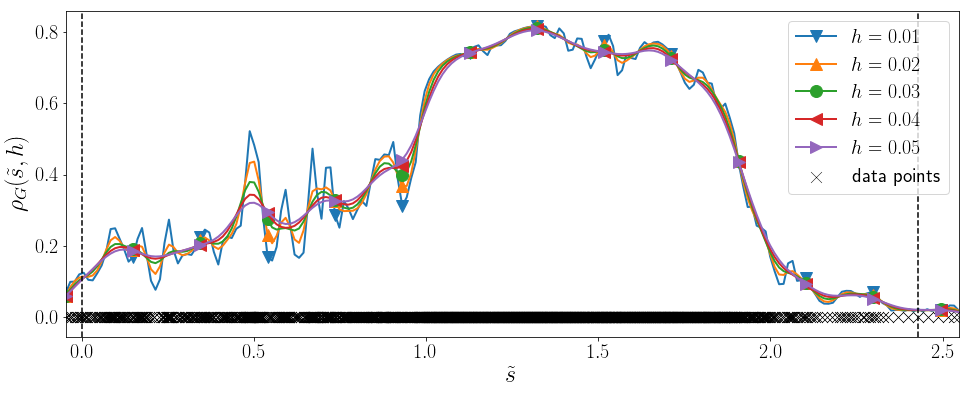

In [15]:
# influence of bandwidth on kernel density estimate
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

s_plot = np.linspace(np.min(length_ext), np.max(length_ext), 200)
marker = ["v", "^", "o", "<", ">"]

for i, bw in enumerate(np.linspace(0.01, 0.05, 5)):
    # sklearn formula
    # scale = (phi-1.0)
    # den = np.mean(np.exp(-np.square(scale)/bw**2/2))/bw/np.sqrt(2*np.pi)
    kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(length_ext[:,np.newaxis])
    log_dens = kde.score_samples(length_ext[:,np.newaxis])
    density = np.exp(log_dens)
    log_dens = kde.score_samples(s_plot[:,np.newaxis])
    ax.plot(s_plot, np.exp(log_dens), lw=2, marker=marker[i], markevery=15, ms=12, label=r"$h={:2.2f}$".format(bw))

ax.scatter(length_ext, np.zeros(length_ext.shape[0]), marker="x", color="k", s=120, lw=0.5, label="data points")
ax.axvline(0.0, ls="--", color="k")
ax.axvline(np.max(length), ls="--", color="k")
ax.set_xlim(np.min(length_ext), np.max(length_ext))
ax.set_xlabel(r"$\tilde{s}$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\rho_G(\tilde{s} ,h)$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)
savefig("arc_length_gaussian_density")

In [16]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.02).fit(length_ext[:,np.newaxis])
log_dens = kde.score_samples(length_ext[:,np.newaxis])
density = np.exp(log_dens)
length_density_01 = (density - np.min(density)) / (np.max(density) - np.min(density))

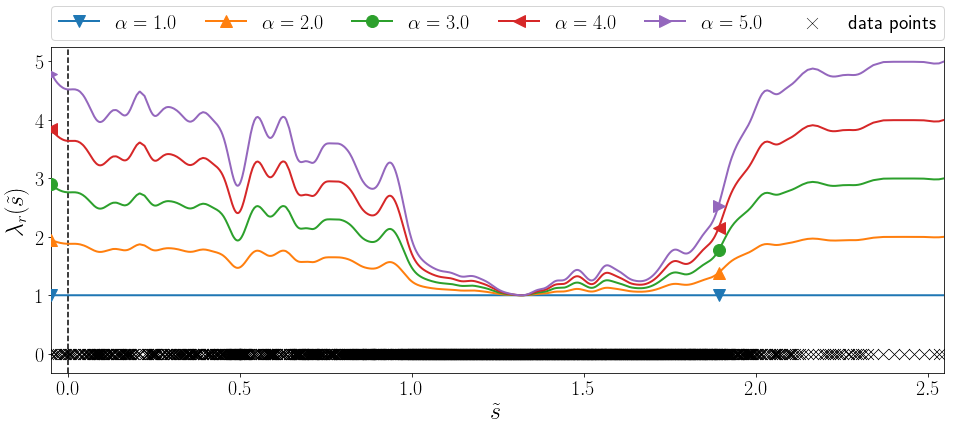

In [17]:
def density_based_weighting(density, alpha):
    return alpha + (1.0 - alpha) * density

rc('text', usetex=True)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

phi_plot = np.linspace(np.min(length_ext), np.max(length_ext), 200)
marker = ["v", "^", "o", "<", ">"]

for i, alpha in enumerate(np.linspace(1, 5, 5)):
    lr = density_based_weighting(length_density_01, alpha)
    ax.plot(length_ext, lr, lw=2, marker=marker[i], markevery=3500, ms=12, label=r"$\alpha={:2.1f}$".format(alpha), zorder=6)

ax.scatter(length_ext, np.zeros(length_ext.shape[0]), marker="x", color="k", s=120, lw=0.5, label="data points")
ax.axvline(0.0, ls="--", color="k")
ax.axvline(np.pi, ls="--", color="k")
ax.set_xlim(np.min(length_ext), np.max(length_ext))
ax.set_xlabel(r"$\tilde{s}$", fontsize=hm.fontsize_label)
ax.set_ylabel(r"$\lambda_r(\tilde{s})$", fontsize=hm.fontsize_label)
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=6, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("dimpled_ellipsoidal_weighting_function")

In [18]:
model_dict = {
    "n_inputs" : 1,
    "n_outputs" : 1,
    "n_layers" : 4,
    "n_neurons" : 40,
    "activation" : torch.nn.functional.selu,
    "batch_norm" : False
}

length_norm = length_ext / np.max(length)
all_losses = {}

epochs = 5000
for case, points_ext, points in zip(["dell_l17_xs", "dell_l17_ys"], [xs_ext, ys_ext], [xs, ys]):
    points_norm = (points_ext - np.min(points)) / (np.max(points) - np.min(points))
    model = hm.SimpleMLP(**model_dict)
    model_path = output_path + "/{}_4layers_40nodes.pt".format(case)
    # weights = density_based_weighting(length_density_01, 10)
    model, losses = hm.training_loop(model, model_path, length_norm, points_norm, None, epochs, 0.001)
    all_losses[case] = losses

100%|██████████| 5000/5000 [01:08<00:00, 73.39it/s]


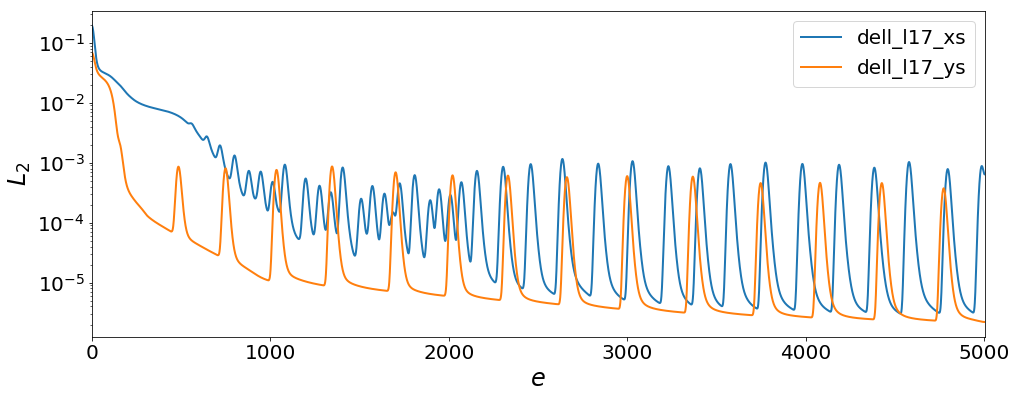

In [19]:
rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(hm.figure_width, 6))

colors = ["C{:1d}".format(i) for i in range(2)]

for i, key in enumerate(all_losses.keys()):
    smoothed = gaussian_filter1d(all_losses[key], sigma=10)
    ax.plot(range(1, epochs+1), smoothed, ls="-", lw=2, color=colors[i], label=key)
    
ax.set_xlabel("$e$", fontsize=hm.fontsize_label)
ax.set_xlim(1, epochs+1)
ax.set_ylabel("$L_2$", fontsize=hm.fontsize_label)
ax.set_yscale('log')
ax.tick_params(labelsize=hm.fontsize_tick)
ax.legend(fontsize=hm.fontsize_legend)
savefig("loss_over_epochs_complex_shape")

In [20]:
def evaluate_complex_shape(model_path_1, model_path_2, s_norm):
    model_1 = hm.SimpleMLP(**model_dict)
    model_1.load_state_dict(torch.load(model_path_1))
    model_1.eval()
    model_2 = hm.SimpleMLP(**model_dict)
    model_2.load_state_dict(torch.load(model_path_2))
    model_2.eval()
    s_eval = torch.from_numpy(s_norm.astype(np.float64)).unsqueeze_(-1)
    xs_model = model_1.forward(s_eval).detach().squeeze().numpy()
    ys_model = model_2.forward(s_eval).detach().squeeze().numpy()
    return xs_model, ys_model

In [21]:
def compute_spline_approximation(x_data, y_data, x_eval, smooth=None):
    if smooth is None:
        tck = interpolate.splrep(x_data, y_data)
    else:
        tck = interpolate.splrep(x_data, y_data, s=smooth)
    return interpolate.splev(x_eval, tck, der=0)

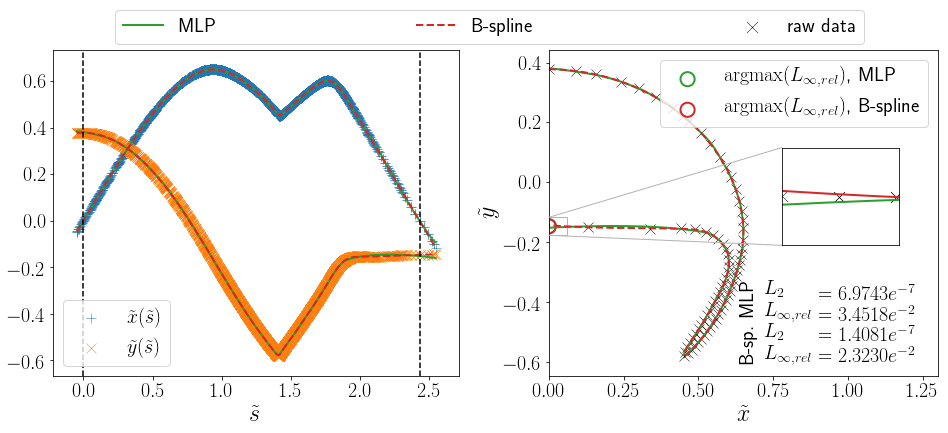

In [22]:
rc('text', usetex=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(hm.figure_width, 6))

model_paths = [output_path + "/{}_4layers_40nodes.pt".format(case) for case in ["dell_l17_xs", "dell_l17_ys"]]
s_plot = np.linspace(np.min(length_ext), np.max(length_ext), 200)
xs_model, ys_model = evaluate_complex_shape(*model_paths, s_plot/np.max(length))
xs_org = xs_model * (np.max(xs) - np.min(xs)) + np.min(xs)
ys_org = ys_model * (np.max(ys) - np.min(ys)) + np.min(ys)

xs_spl = compute_spline_approximation(length_ext, xs_ext, s_plot, smooth=0.001)
ys_spl = compute_spline_approximation(length_ext, ys_ext, s_plot, smooth=0.001)

# left plot
line0 = ax1.plot(s_plot, xs_org, color="C2", ls="-", lw=2, label="MLP")
ax1.plot(s_plot, ys_org, color="C2", ls="-", lw=2)

line1 = ax1.plot(s_plot, xs_spl, color="C3", ls="--", lw=2, label="B-spline")
ax1.plot(s_plot, ys_spl, color="C3", ls="--", lw=2)

sca0 = ax1.scatter(length_ext, xs_ext, color="C0", marker="+", s=100, lw=0.5, label=r"$\tilde{x}(\tilde{s})$")
sca1 = ax1.scatter(length_ext, ys_ext, color="C1", marker="x", s=100, lw=0.5, label=r"$\tilde{y}(\tilde{s})$")
ax1.axvline(0.0, 0.0, 1.0, ls="--", color="k")
ax1.axvline(np.max(length), 0.0, 1.0, ls="--", color="k")
ax1.set_xlabel(r"$\tilde{s}$", fontsize=hm.fontsize_label)
ax1.legend(handles=[sca0, sca1], fontsize=hm.fontsize_legend)

# right plot
s_plot = np.linspace(0, np.max(length), 200)
xs_model, ys_model = evaluate_complex_shape(*model_paths, s_plot/np.max(length))
xs_org = xs_model * (np.max(xs) - np.min(xs)) + np.min(xs)
ys_org = ys_model * (np.max(ys) - np.min(ys)) + np.min(ys)
xs_spl = compute_spline_approximation(length, xs, s_plot, smooth=0.001)
ys_spl = compute_spline_approximation(length, ys, s_plot, smooth=0.001)

# evaluate deviation from reference data
xsp_model, ysp_model = evaluate_complex_shape(*model_paths, length/np.max(length))
xsp_org = xsp_model * (np.max(xs) - np.min(xs)) + np.min(xs)
ysp_org = ysp_model * (np.max(ys) - np.min(ys)) + np.min(ys)
xsp_spl = compute_spline_approximation(length, xs, length, smooth=0.001)
ysp_spl = compute_spline_approximation(length, ys, length, smooth=0.001)
radp_model = np.sqrt(np.square(xsp_org) + np.square(ysp_org))
radp_spl = np.sqrt(np.square(xsp_spl) + np.square(ysp_spl))
rad_ref = np.sqrt(np.square(xs) + np.square(ys))
diff_mlp = np.absolute(radp_model - rad_ref)
diff_spl = np.absolute(radp_spl - rad_ref)

ax2.scatter(xs[::50], ys[::50], marker="x", s=100, lw=0.5, color="k")
ax2.plot(xs_org, ys_org, color="C2", lw=2, ls="-", label="MLP")
ax2.plot(xs_spl, ys_spl, color="C3", lw=2, ls="--", label="B-spline")
sca3 = ax2.scatter([xs[np.argmax(diff_mlp/rad_ref)]],[ys[np.argmax(diff_mlp/rad_ref)]],
                     marker="o", facecolors='none', edgecolors='C2', s=200, lw=2,
                     label="$\mathrm{argmax}(L_{\infty,rel})$, MLP")
sca4 = ax2.scatter([xs[np.argmax(diff_spl/rad_ref)]],[ys[np.argmax(diff_spl/rad_ref)]],
                     marker="o", facecolors='none', edgecolors='C3', s=200, lw=2,
                     label="$\mathrm{argmax}(L_{\infty,rel})$, B-spline")

ax2.legend(handles=[sca3, sca4], fontsize=hm.fontsize_legend)

# zoom window(s)
max_diff_ind = np.argmax(diff_mlp/rad_ref)
x_mpos = xs[max_diff_ind]
y_mpos = ys[max_diff_ind]
win = 0.03
zoom_1 = plt.axes([0.6, 0.4, 0.1, 0.1], xticks=[], yticks=[],
                  xlim=[x_mpos, x_mpos+2*win], ylim=[y_mpos-win, y_mpos+win])
ip_1 = InsetPosition(ax2, [0.6, 0.4, 0.3, 0.3])
zoom_1.set_axes_locator(ip_1)
mark_inset(ax2, zoom_1, loc1=2, loc2=3, fc="none", ec='0.7')
zoom_1.plot(xs_org, ys_org, color="C2", lw=2)
zoom_1.plot(xs_spl, ys_spl, color="C3", lw=2)
sca4 = zoom_1.scatter(xs, ys, color="k", lw=0.5, s=120, marker="x", label="raw data")

# plot error norms
ax2.text(0.72, -0.6, "$L_2$\n$L_{\infty,rel}$\n$L_2$\n$L_{\infty,rel}$", fontsize=hm.fontsize_tick)
ax2.text(0.90, -0.6, "$=" + format_exp_latex(np.mean(np.square(diff_mlp))) + "$\n"
                  + "$=" + format_exp_latex(np.max(diff_mlp/rad_ref)) + "$\n"
                  + "$=" + format_exp_latex(np.mean(np.square(diff_spl))) + "$\n"
                  + "$=" + format_exp_latex(np.max(diff_spl/rad_ref)) + "$", fontsize=hm.fontsize_tick)
ax2.text(0.635, -0.37, "MLP", rotation=90, fontsize=hm.fontsize_tick)
ax2.text(0.635, -0.52, "B-sp.", rotation=90, fontsize=hm.fontsize_tick)

# formatting
ax2.set_xlim(0.0, 1.3)
ax2.set_aspect("equal")
ax2.set_xlabel(r"$\tilde{x}$", fontsize=hm.fontsize_label)
ax2.set_ylabel(r"$\tilde{y}$", fontsize=hm.fontsize_label)



for ax in [ax1, ax2]:
    ax.tick_params(labelsize=hm.fontsize_tick)

fig.legend(handles=[line0[0], line1[0], sca4], bbox_to_anchor=(0.1, 0.90, 0.65, .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0., fontsize=hm.fontsize_legend)
savefig("xy_as_function_of_s")

## Export shapes as stl

In [23]:
height = 0.1

for i, case in enumerate(["scap_l16", "wa18_l16", "dell_l17"]):
    if case is "dell_l17":
        s_plot = np.linspace(0.0, np.max(length), 600)
        x = compute_spline_approximation(length_ext, xs_ext, s_plot, smooth=0.001)
        y = compute_spline_approximation(length_ext, ys_ext, s_plot, smooth=0.001)
    else:
        model_path = output_path + "/{}_4layers_40nodes.pt".format(case)
        rad_model, phi_model = evaluate_shape_model(model_path, all_facets[case], False)
        x, y = hm.transform_cartesian_2D(rad_model, phi_model)
    tri_list = []
    for t in range(len(x)-1):
        # upper triangle
        tri_list.append(hm.Triangle(np.asarray([x[t], y[t], 0.0]),
                                    np.asarray([x[t+1], y[t+1], height]),
                                    np.asarray([x[t], y[t], height]))
                        )
        # lower triangle
        tri_list.append(hm.Triangle(np.asarray([x[t], y[t], 0.0]),
                                    np.asarray([x[t+1], y[t+1], 0.0]),
                                    np.asarray([x[t+1], y[t+1], height]))
                         )
    path = "../output/STL/" + case + ".stl"
    hm.triangles_to_stl(path, "bubble", tri_list)
    print("Exported file {}".format(path))

Exported file ../output/STL/scap_l16.stl
Exported file ../output/STL/wa18_l16.stl
Exported file ../output/STL/dell_l17.stl
